## 0 - Librairies

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Masking, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

2025-09-24 17:59:18.984130: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-24 17:59:19.147248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-24 17:59:22.447711: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


## 1 - Data Preparation

In [2]:
train_df = pd.read_csv("Data/Swissprot_Train_Validation_dataset.csv")

In [3]:
labels = train_df.drop(columns=["ACC", "Sequence", "Kingdom", "Unnamed: 0", "Partition"]).values

In [4]:
amino_acids = sorted(set(''.join(train_df["Sequence"])))
aa_to_index = {aa: i+1 for i, aa in enumerate(amino_acids)}  # +1  (0 reserved to padding)
vocab_size = len(amino_acids) + 1  # +1 for padding

In [5]:
# Function to transform and encode a sequence in one pass
def transform_and_encode_sequence(sequence, aa_to_index, max_length=1000):
    """
    Transform and encode a sequence of amino acids according to the following rules:
    - If the sequence is shorter than max_length, pad with zeros.
    - If the sequence is longer than max_length, keep the first 500 and last 500 amino acids.
    """
    # Encode sequence as indices
    encoded = np.array([aa_to_index.get(aa, 0) for aa in sequence], dtype=np.int32)

    # Transform sequence
    if len(encoded) < max_length:
        # Pad with zeros
        transformed = np.zeros(max_length, dtype=np.int32)
        transformed[:len(encoded)] = encoded
    else:
        # Keep first 500 and last 500 amino acids
        transformed = np.concatenate([encoded[:500], encoded[-500:]])

    return transformed

In [6]:
# Apply transformation and encoding directly to sequences
X = np.array([transform_and_encode_sequence(seq, aa_to_index) for seq in train_df["Sequence"]])

In [7]:
print("Shape of X:", X.shape)
print("Example of transformed sequence:\n", X[0, :10])

Shape of X: (28303, 1000)
Example of transformed sequence:
 [12  1  1  1  1  1  1  1  1  1]


In [8]:
print("Shape of y:", labels.shape)
print("Example of labels:\n", labels[0])

Shape of y: (28303, 11)
Example of labels:
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## 2 - Modele GRU


### Parameters

In [9]:
test_size = 0.2
embedding_dim = 32
epochs = 30
loss = 'binary_crossentropy'
metrics = ['accuracy']
monitor_callback = "val_accuracy"
patience_callback = 4
mode_callback = None #"max"

In [10]:
# Split data into training, testing and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=test_size)

In [11]:
param_grid = {
    'learning_rate': [0.001],
    'dropout_rate': [0.2],   #   [0.2, 0.3]
    'batch_size': [64]    #   [32, 64]
}

In [12]:
def create_and_train_model(X_train, y_train, learning_rate, dropout_rate, batch_size, epochs):
    model = Sequential([
    # Embedding layer to transform indices into dense vectors
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=1000,
        mask_zero=True  # Mask zeros (padding)
    ),

    Masking(mask_value=0.0),
    Bidirectional(GRU(128, return_sequences=True)),
    Dropout(dropout_rate),
    Bidirectional(GRU(64)),
    Dropout(dropout_rate),
    Dense(64),
    Dropout(dropout_rate),
    Dense(11, activation='sigmoid')  # Ensure the number of neurons matches y.shape[1]
])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.2,
        verbose=1,
        callbacks=[EarlyStopping(monitor=monitor_callback, patience=patience_callback, mode=mode_callback, restore_best_weights=True)]
    )
    return model, history

In [ ]:
best_score = -np.inf
best_params = {}
best_model = None
best_history = None

# Grid search but manually (GridSearch does not work...)
for learning_rate in param_grid['learning_rate']:
    for dropout_rate in param_grid['dropout_rate']:
        for batch_size in param_grid['batch_size']:

              print(f"Testing: lr={learning_rate}, dropout={dropout_rate}, batch_size={batch_size}")

              model, history = create_and_train_model(X_train, y_train, learning_rate, dropout_rate, batch_size, epochs)
              val_accuracy = history.history['val_accuracy'][-1]

              if val_accuracy > best_score:
                  best_score = val_accuracy
                  best_model = model
                  best_history = history

                  best_params = {
                      'learning_rate': learning_rate,
                      'dropout_rate': dropout_rate,
                      'batch_size': batch_size
                    }

Testing: lr=0.001, dropout=0.2, batch_size=64


/home/hugob/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
E0000 00:00:1758729568.480114   25388 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1758729568.503422   25388 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


/home/hugob/Projets/2-Projets_courts/.venv/lib/python3.13/site-packages/keras/src/callbacks/early_stopping.py:77: UserWarning: EarlyStopping mode 'None' is unknown, fallback to auto mode.
  super().__init__(monitor, mode, min_delta=min_delta)


Epoch 1/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 1132s 4s/step - accuracy: 0.3390 - loss: 0.3458 - val_accuracy: 0.4763 - val_loss: 0.2804
Epoch 2/30
284/284 ━━━━━━━━━━━━━━━━━━━━ 1116s 4s/step - accuracy: 0.5199 - loss: 0.2736 - val_accuracy: 0.5156 - val_loss: 0.2605
Epoch 3/30
 36/284 ━━━━━━━━━━━━━━━━━━━━ 17:05 4s/step - accuracy: 0.5185 - loss: 0.2726

## 3 - Results

In [ ]:
print(f"Best validation score: {best_score:.4f}")
print(f"Best parameters: {best_params}")

Meilleur score de validation: 0.3074
Meilleurs paramètres: {'learning_rate': 0.01, 'dropout_rate': 0.3, 'batch_size': 64}


In [ ]:
best_model.summary()

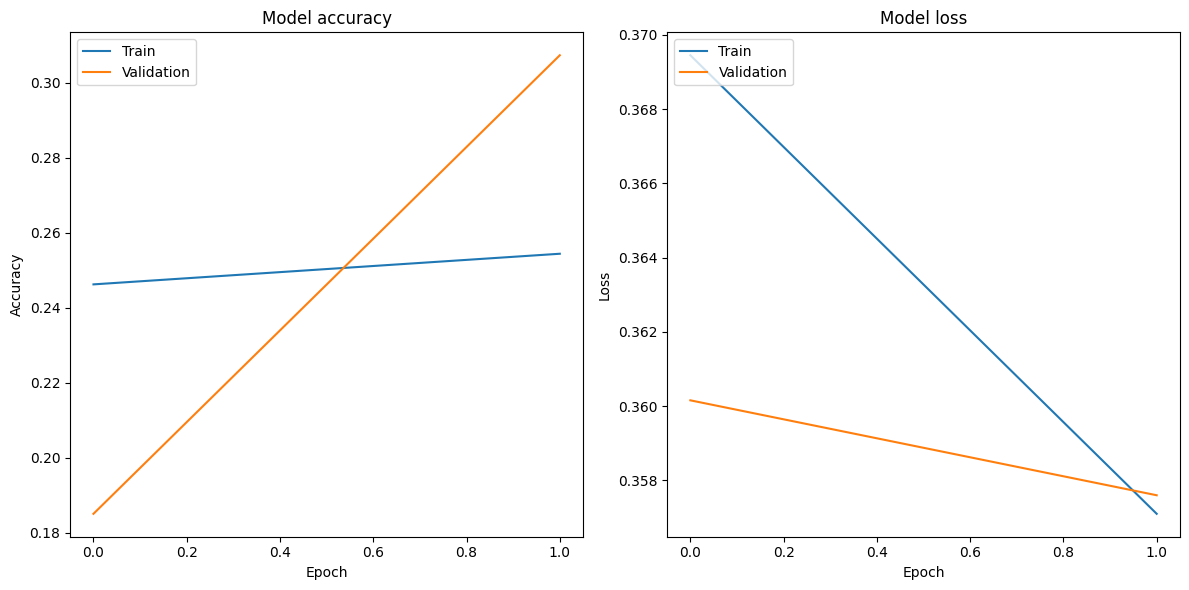

In [ ]:
# Accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_history.history['accuracy'])
plt.plot(best_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Loss
plt.subplot(1, 2, 2)
plt.plot(best_history.history['loss'])
plt.plot(best_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.3564
Test Accuracy: 0.3104


In [ ]:
# Predict classes using the cnn model
y_pred_cnn = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred_cnn, axis=1)

In [ ]:
# Confusion matrix
matrix = confusion_matrix(y_test, y_pred_classes)  # Compare true labels (y_test) and predicted labels (y_pred_classes_dense)

# Plot confusion matrix
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix (CNN Modele)')
plt.show()

# Calculate Sensitivity (SEV) and Specificity (SPE) for each class
for i in range(matrix.shape[0]):
    tp = matrix[i, i]
    fn = np.sum(matrix[i, :]) - tp
    fp = np.sum(matrix[:, i]) - tp
    tn = np.sum(matrix) - tp - fn - fp
    f1 = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0  # F1-score
    sev = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity (Recall)
    spe = tn / (tn + fp) if (tn + fp) > 0 else 0  # Specificity
    accuracy = (tn + tp) / (tp + fn + tn + fp)
    print(f'Class {i}:')
    print(f'  Sensitivity (SEV): {sev:.4f}')
    print(f'  Specificity (SPE): {spe:.4f}')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  F1-score: {f1:.4f}\n')